## Load libraries and configs

In [1]:
import os 
import json
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

tf.config.list_physical_devices()

2025-03-18 10:46:30.106581: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 10:46:30.190804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 10:46:30.210268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 10:46:30.215914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 10:46:30.294844: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
CHARTS = ["Bar", "Line", "Pie"]
EPOCHS = 20
BATCH_SIZE = 32

In [14]:
import keras_tuner as kt

## Data Preparing

In [8]:
cls_train_images = "./../../assets/dataset/test/clsdata(1031)/cls/images/train2019/"
cls_val_images = "./../../assets/dataset/test/clsdata(1031)/cls/images/val2019/"
cls_test_images = "./../../assets/dataset/test/clsdata(1031)/cls/images/test2019/"

cls_train_annotations = "./../../assets/dataset/test/clsdata(1031)/cls/annotations/instancesCls(1031)_train2019.json"
cls_val_annotations = "./../../assets/dataset/test/clsdata(1031)/cls/annotations/instancesCls(1031)_val2019.json"
cls_test_annotations = "./../../assets/dataset/test/clsdata(1031)/cls/annotations/instancesCls(1031)_test2019.json"

In [9]:
with open(cls_test_annotations) as f:
    cls_test_data = json.load(f)
    test_annotations_df = pd.DataFrame(cls_test_data['images'])
    test_annotations_df['data_type'] = test_annotations_df['data_type'].astype(str)
    
with open(cls_train_annotations) as f:
    cls_train_data = json.load(f)
    train_annotations_df = pd.DataFrame(cls_train_data['images'])
    train_annotations_df['data_type'] = train_annotations_df['data_type'].astype(str)
    
with open(cls_val_annotations) as f:
    cls_val_data = json.load(f)
    val_annotations_df = pd.DataFrame(cls_val_data['images'])
    val_annotations_df['data_type'] = val_annotations_df['data_type'].astype(str)

Take a look at 9 random images and it classes.

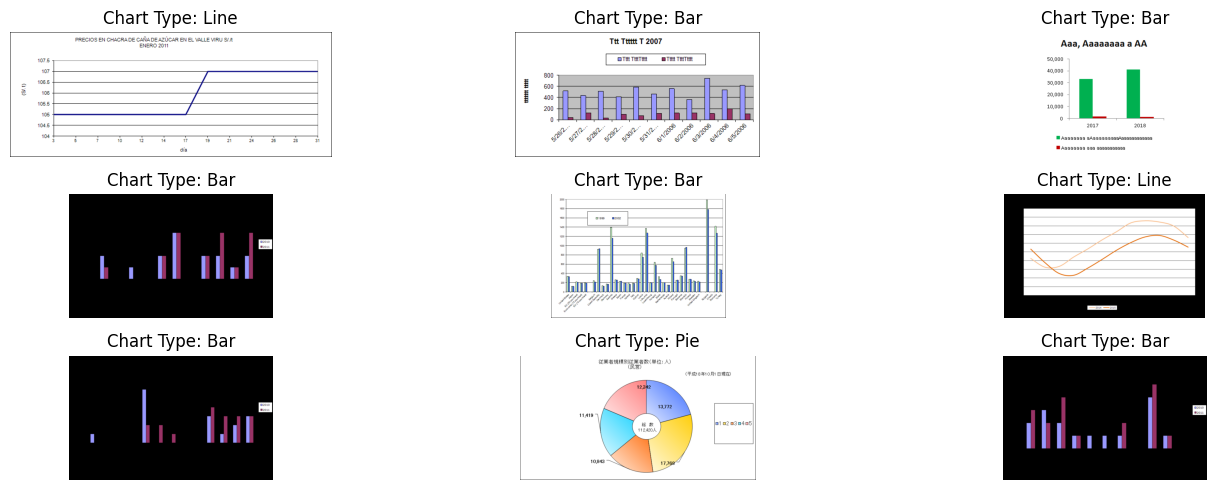

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes = axes.ravel()

for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(train_annotations_df))
    img_path = os.path.join(cls_train_images, train_annotations_df.iloc[idx]['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    chart_type = train_annotations_df.iloc[idx]['data_type']
    
    ax.set_title(f"Chart Type: {CHARTS[int(chart_type)]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Create `ImageDataGenerator`

In [21]:
datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = datagen.flow_from_dataframe(
    train_annotations_df,
    directory=cls_train_images,
    x_col='file_name',
    y_col='data_type', 
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    val_annotations_df,
    directory=cls_val_images,
    x_col='file_name',
    y_col='data_type', 
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_annotations_df,
    directory=cls_test_images,
    x_col='file_name',
    y_col='data_type', 
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # To keep the order of the images same as the order of the labels
)

Found 200 validated image filenames belonging to 3 classes.
Found 9 validated image filenames belonging to 3 classes.


Found 9 validated image filenames belonging to 3 classes.


Transfer learning with **MobileNetV2**

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
def build_modeL(hp):
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    model = Sequential([
        Input(shape=(224, 224, 3)),
        base_model,
        GlobalMaxPool2D(),
        Dense(
            units=hp.Int('dense_1_units', min_value=128, max_value=512, step=128),
            activation='relu'
        ),
        Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_2_units', min_value=32, max_value=128, step=32),
            activation='relu'
        ),
        Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Initialize the tuner

In [24]:
tuner = kt.RandomSearch(
    build_modeL,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_search',
    project_name='chart_cls_tuning'
)

Display search space summary

In [25]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


Perform the hyperparameter search

In [26]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3
)

In [27]:
tuner.search(
    train_generator,
    validation_data = val_generator,
    epochs = EPOCHS,
    callbacks = [early_stopping]
)

Trial 10 Complete [00h 00m 12s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 20s


In [28]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'dense_1_units': 384, 'dropout_1': 0.4, 'dense_2_units': 128, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.0005371117831720339}


Build the best model

In [29]:
best_model = tuner.hypermodel.build(best_hps)

In [30]:
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, ModelCheckpoint('best_chart_cls.keras', monitor='val_loss', save_best_only=True)
]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5234 - loss: 2.9325 - val_accuracy: 0.7778 - val_loss: 0.2277
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9249 - loss: 0.2633 - val_accuracy: 1.0000 - val_loss: 0.0834
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8909 - loss: 0.6113 - val_accuracy: 1.0000 - val_loss: 0.0482
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9007 - loss: 0.2298 - val_accuracy: 1.0000 - val_loss: 0.0975
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9768 - loss: 0.1579 - val_accuracy: 0.7778 - val_loss: 0.4635
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9306 - loss: 0.3619 - val_accuracy: 0.7778 - val_loss: 1.4872


In [31]:
best_model.save('best_chart_cls.keras')

## Evaluating

Line plot of learning curve

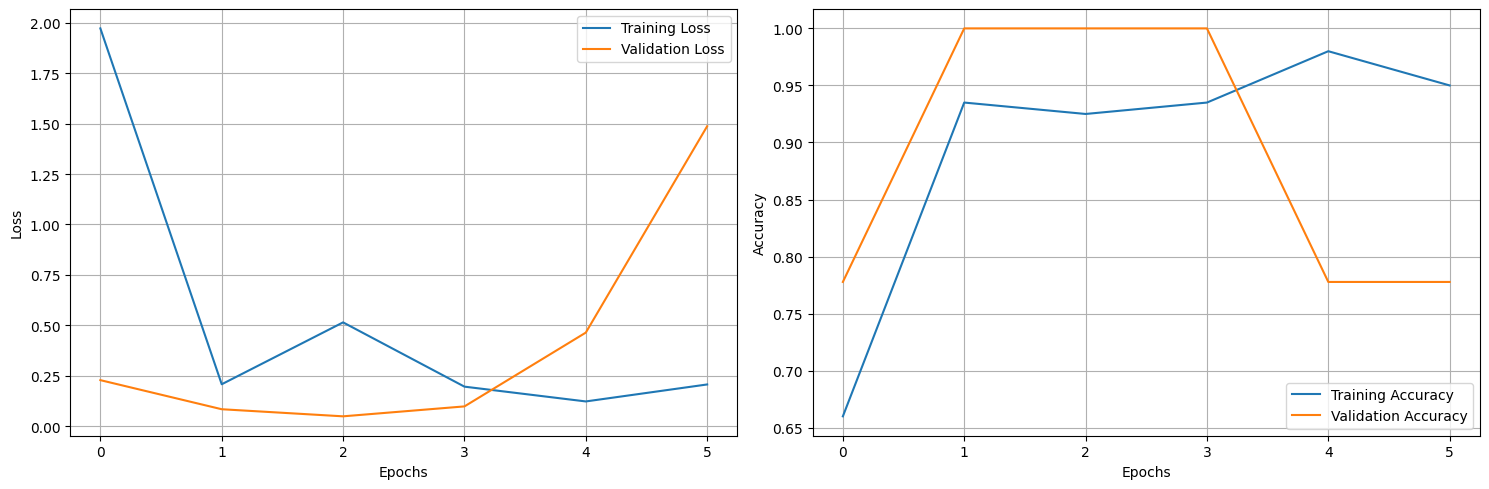

In [32]:
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_df['loss'], label='Training Loss')
axes[0].plot(history_df['val_loss'], label='Validation Loss')

axes[1].plot(history_df['accuracy'], label='Training Accuracy')
axes[1].plot(history_df['val_accuracy'], label='Validation Accuracy')

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlabel('Epochs')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [33]:
# Evaluate the model
best_model.evaluate(test_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0047 


/home/vietz/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[0.0036991413217037916, 1.0]

In [34]:
preds = best_model.predict(test_generator)
pred_labels = np.argmax(preds, axis=1)

true_labels = test_generator.labels

print("Sklearn accuracy:", accuracy_score(true_labels, pred_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Sklearn accuracy: 1.0


In [35]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



Cunfusion matrix of actual class and predicted

In [36]:
cm = confusion_matrix(true_labels, pred_labels)

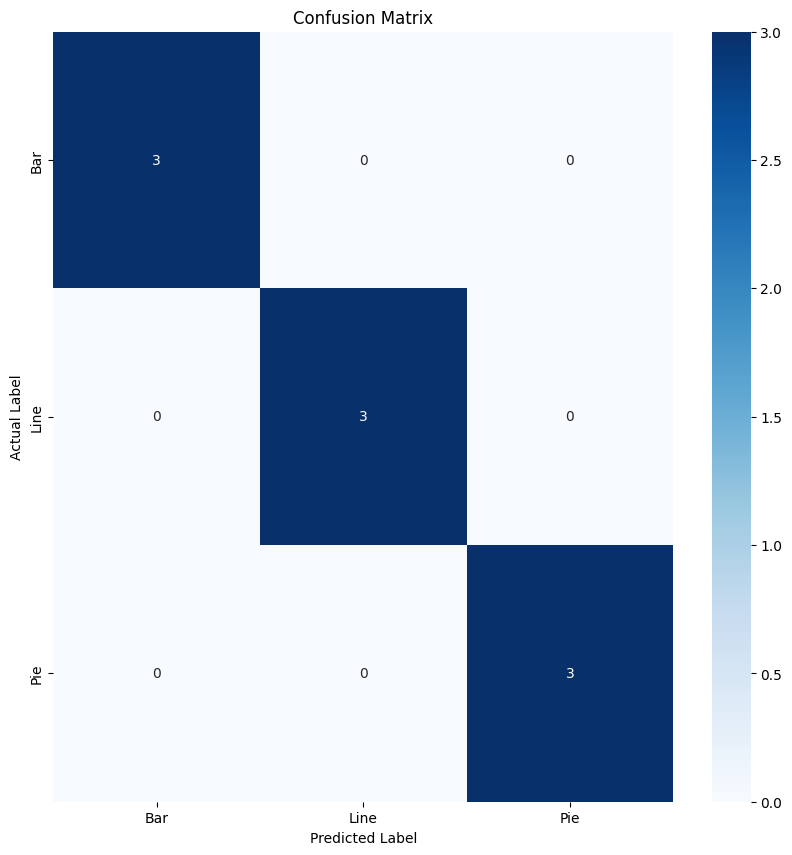

In [37]:
plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xticks(ticks=np.arange(3) + 0.5, labels=CHARTS)
plt.yticks(ticks=np.arange(3) + 0.5, labels=CHARTS)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')

plt.show()

Show 10 random images with their predicted and actual chart type

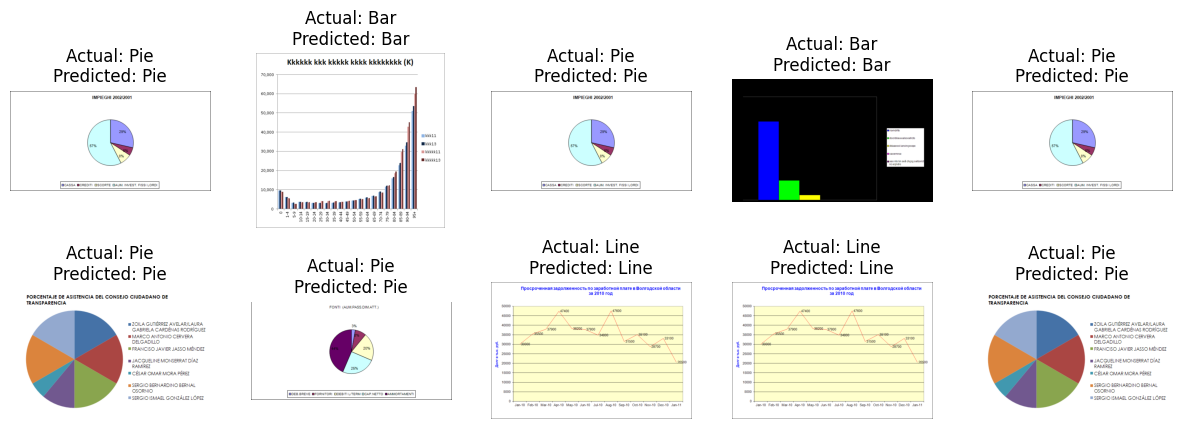

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.ravel()

for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(test_annotations_df))
    img_path = os.path.join(cls_test_images, test_annotations_df.iloc[idx]['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    chart_type = test_annotations_df.iloc[idx]['data_type']
    predicted = pred_labels[idx]
    
    ax.set_title(f"Actual: {CHARTS[int(chart_type)]}\nPredicted: {CHARTS[predicted]}")
    ax.axis('off')

Show 9 missclassified images

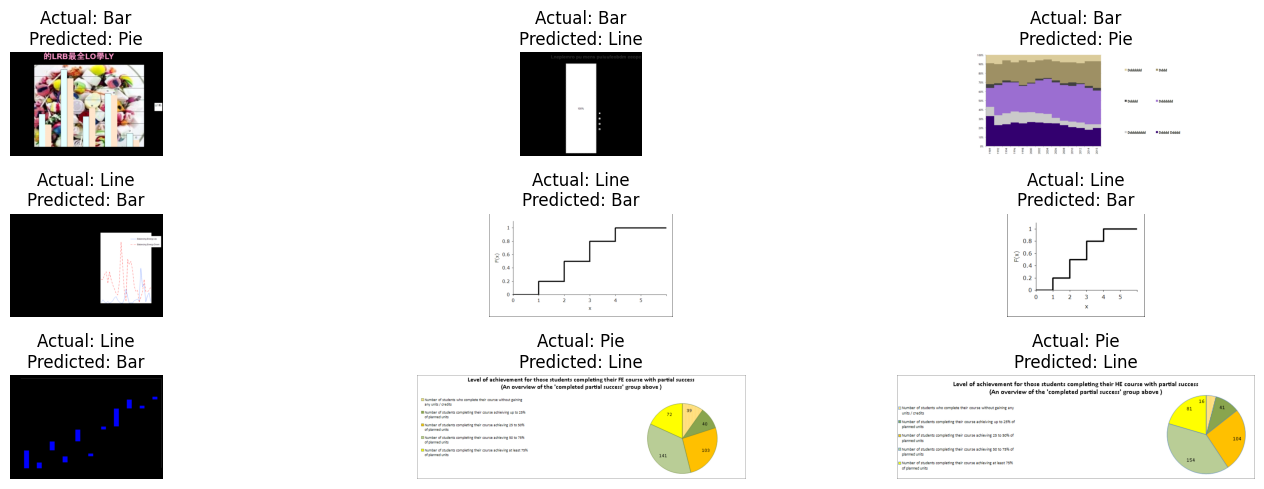

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes = axes.ravel()

missclassified = np.where(true_labels != pred_labels)[0]

for i, ax in enumerate(axes):
    idx = missclassified[i]
    img_path = os.path.join(cls_test_images, test_annotations_df.iloc[idx]['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    chart_type = test_annotations_df.iloc[idx]['data_type']
    predicted = pred_labels[idx]
    
    ax.set_title(f"Actual: {CHARTS[int(chart_type)]}\nPredicted: {CHARTS[predicted]}")
    ax.axis('off')

plt.tight_layout()
plt.show()